### 173 samples, Final_R is missing for the following sample
137)	MC	air	204	8	180	60	180	500	30	114	0.3	NA	150	0.3	100	0.490196078	486.395	57.78712883	26.00664167	0.467	9.68631173	3	0.422680412	0.541775715	0.521526486	44.36424367

In [1]:
# Import Python libaries
%matplotlib inline
from scipy.optimize import curve_fit
import time as time
# General data management
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rc, rcParams

import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn import linear_model
from sklearn import ensemble
from xgboost import plot_tree
from sklearn.tree import DecisionTreeRegressor
# import pydo
# generate random integer values
from random import seed
from random import randint
# seed random number generator
seed(1)
# Machine learning & model visualization tools
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, LeaveOneOut
from sklearn.metrics import r2_score, mean_squared_error, mean_gamma_deviance, mean_absolute_error
from sklearn.tree import export_graphviz
from sklearn import svm
from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor
from numpy import cov
from scipy.stats import pearsonr
from scipy import ndimage, misc

from scipy import stats 
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import MinMaxScaler
# from sklearn.externals import joblib
# Miscellaneous
import os
import io
import pydot
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as BK
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
#tf.test.is_gpu_available(cuda_only=False, min_cuda_compute_capability=None)

import statsmodels.api as sm
import statsmodels.formula.api as smf
#from sklearn.inspection import partial_dependence, plot_partial_dependence

global_rand_state_split = 9
global_rand_state_xgb = 9

2023-01-22 08:10:56.018800: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-22 08:10:56.615388: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/home/kianoosh/anaconda3/envs/tf/lib/
2023-01-22 08:10:56.615450: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib/cuda/include:/usr/lib/cuda/lib64::/home/

Text(0.5, 0, '!!!Ariaaaal')

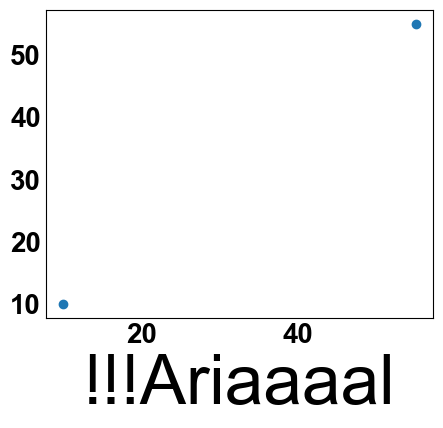

In [2]:
# check the font !!!!!!!!!!!!!!!!!!!!!
# switch to Arial
# if not working: delet ~/.catch/matplotlib
plt.rcParams["font.family"] = "Arial"
plt.rcParams['ps.useafm'] = True
plt.rcParams['pdf.fonttype'] = 42
mpl.font_manager.FontManager()

rc('font', weight='bold')
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter([10, 55], [10, 55])
ax.tick_params(axis='both', length=0, width=1.5, colors='black', grid_alpha=0, labelsize=20)
plt.xlabel('!!!Ariaaaal', fontname='Arial', fontsize=50)

In [3]:
# proxy properties
# read the input data
df = pd.read_csv('FJH_ML_Final_simulation.csv', header=1)
df_dummy = pd.get_dummies(df)

df['Norm_charge_tot'] = df['Charge_Tot']/(df['Mass'])*1000
df['Norm_I_Max'] = df['I_Max']/df['Mass']*1000
df['charge_density'] = df['Voltage']*df['Cap']/df['Mass']
df['Final_Current_Percent'] = df['I_Final']/df['I_Max']
Norm_I_Max = np.array (df['Norm_I_Max']).reshape(-1, 1)
Final_Current_Percent  = np.array (df['Final_Current_Percent']).reshape(-1, 1)
Norm_charge_tot  = np.array (df['Norm_charge_tot']).reshape(-1, 1)
# final prediction, yield of Graphene
df['Graphene_Yield'] = 100*df['Graphene_Yield']
Graphene_Yield = np.array (df['Graphene_Yield']).reshape(-1, 1)

# only process parameters that are in BO prediction
Pretreat_voltage = np.array (df['Pretreat_voltage']).reshape(-1, 1)
pulsetime = np.array (df['PulseTime']).reshape(-1, 1)
charge_denisty = np.array (df['charge_density']).reshape(-1, 1)
temp1 = np.array (df['temp1']).reshape(-1, 1)
temp2 = np.array (df['temp2']).reshape(-1, 1)

Text(0, 0.5, 'Graphene Yield(%)')

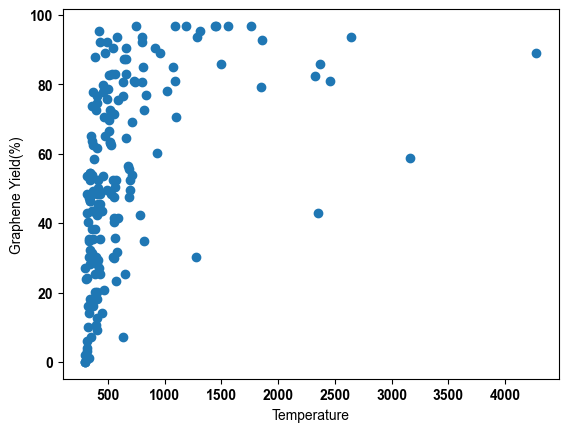

In [4]:
plt.scatter(temp1, Graphene_Yield)
plt.xlabel('Temperature')
plt.ylabel('Graphene Yield(%)')

Text(0, 0.5, 'Graphene Yield(%)')

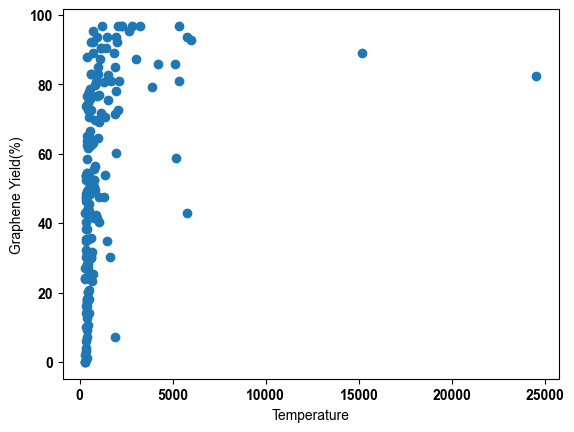

In [5]:
plt.scatter(temp2, Graphene_Yield)
plt.xlabel('Temperature')
plt.ylabel('Graphene Yield(%)')

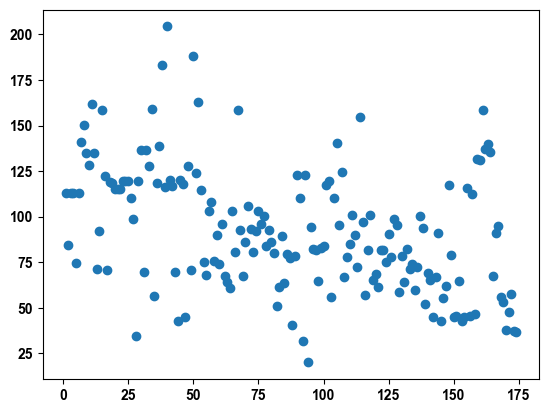

In [202]:
df_CB = df.loc[df['Material']!='TB'].copy()
#plt.scatter (x=list(range(df_CB.shape[0])), y=df_CB['charge_density'])
plt.scatter (x=df_CB['Sample'], y=df_CB['charge_density'])

PearsonRResult(statistic=0.638757740394549, pvalue=2.4751583964853448e-21)
-17.144091366793667


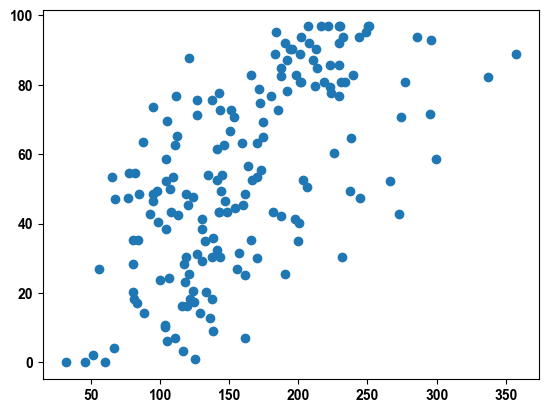

In [203]:
# CB: pearson r for CV vs. GY = 0.58 ---> 0.62
# MC: pearson r for CV vs. GY = 0.28 ---> 0.31
# PA: pearson r for CV vs. GY = 0.52 ---> 0.53
# TCB: pearson r for CV vs. GY = 0.53 --> 0.56
# use this one. 
df_CB ['cdTtime'] = df_CB['charge_density']*(df_CB['PulseTime'])**0.1
df_CB ['cdTtime']
plt.scatter (x=df_CB ['cdTtime'].loc[df_CB['cdTtime']>0], y=df_CB['Graphene_Yield'].loc[df_CB['cdTtime']>0])
#df_CB['']
print (pearsonr (x=df_CB ['cdTtime'].loc[df_CB['cdTtime']>0], y=df_CB['Graphene_Yield'].loc[df_CB['cdTtime']>0]))
print (r2_score (df_CB['Graphene_Yield'].loc[df_CB['cdTtime']>0], df_CB ['cdTtime'].loc[df_CB['cdTtime']>0]))

In [204]:
# same value you get from excel
pearsonr(df['charge_density'], df['Graphene_Yield'])[0]**2

0.3709854542984945

PearsonRResult(statistic=0.6090857528283636, pvalue=4.781351229742724e-19)


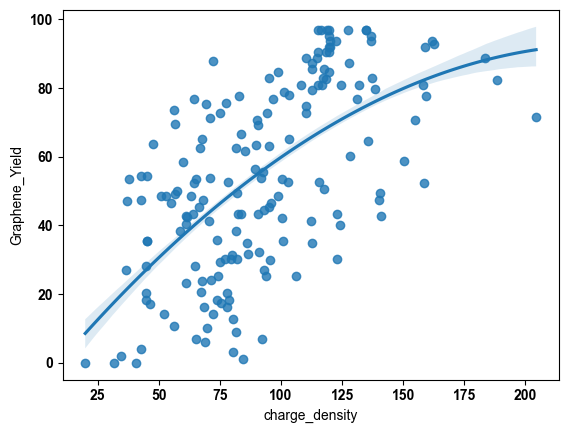

In [15]:
df_capTvolt = df.loc[df['Material']!='C'].copy()
df_capTvolt ['capTvolt'] = df['Cap']*df['Voltage']/1000
sns_cv_gy = sns.regplot(data=df_capTvolt, x='charge_density', y='Graphene_Yield', order=2, ci=50)
print (pearsonr(df_capTvolt ['charge_density'] , df_capTvolt ['Graphene_Yield'] ))

/tmp/ipykernel_647005/31923920.py:22: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


<Axes.ArtistList of 0 artists>
<Axes.ArtistList of 0 artists>
<Axes.ArtistList of 0 artists>
PearsonRResult(statistic=0.5175072123378059, pvalue=2.888343018260227e-10)


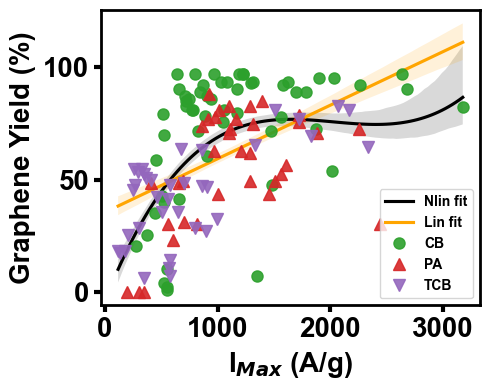

In [11]:
# relation of I_max and GY depend on material group. 
df_notMC = df.loc[df['Material'] !='MC']
fig, ax = plt.subplots(figsize=(5, 4))
sns1= sns.regplot(data=df_notMC, x='Norm_I_Max', y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "black"},
            ci=70, order=3, scatter=False, label='Nlin fit')#hue='Material')
sns1.legend()
sns2= sns.regplot(data=df_notMC, x='Norm_I_Max', y='Graphene_Yield', 
            scatter_kws={"color": "red"}, line_kws={"color": "orange"},
            ci=70, order=1, scatter=False, label='Lin fit')#hue='Material')
sns2.legend()
#plt.legend(handles=[sns1, sns2])
#plt.legend(['Lin fit'])
#plt.legend(('Nlin fit', '', 'Lin fit'), loc='upper left')

groups = df_notMC.groupby(['Material'])

markers = ['o', '^', 'v']
colors=['blue', 'orange', 'green']

counter = 0
for name, group in groups:
    ax.plot(group.Norm_I_Max, group.Graphene_Yield, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    print (ax.artists)
    counter+=1
plt.legend(loc='lower right')

plt.xlabel(r'I$_{Max}$ (A/g)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('Graphene Yield (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(2) for i in ax.spines.values()]

plt.tight_layout()
plt.savefig('Imax_GY_notMC.jpeg', dpi=500)
print (pearsonr(df_notMC['Norm_I_Max'], df_notMC['Graphene_Yield']))

PearsonRResult(statistic=0.2611109730168967, pvalue=0.08689789694650739)


/tmp/ipykernel_647005/3895307339.py:18: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


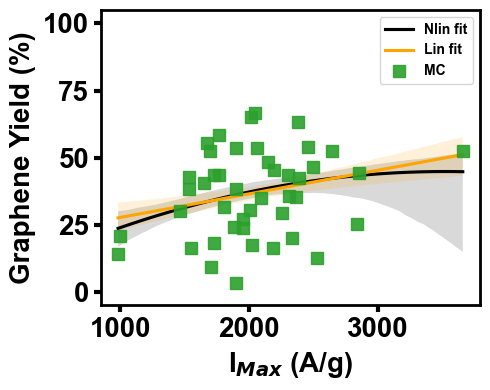

In [12]:
# relation of I_max and GY depend on material group. 
df_MC = df.loc[df['Material'] =='MC']
fig, ax = plt.subplots(figsize=(5, 4))
sns1 = sns.regplot(data=df_MC, x='Norm_I_Max', y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "black"},
            ci=70, order=2, scatter=False, label='Nlin fit')#hue='Material')
sns1.legend()
sns2 = sns.regplot(data=df_MC, x='Norm_I_Max', y='Graphene_Yield', 
            scatter_kws={"color": "black"}, line_kws={"color": "orange"},
            ci=70, order=1, scatter=False, label='Lin fit')#hue='Material')
sns2.legend()
groups = df_MC.groupby(['Material'])

markers = ['s', ]
colors=['orange',]

counter = 0
for name, group in groups:
    ax.plot(group.Norm_I_Max, group.Graphene_Yield, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    counter+=1
plt.legend(loc='upper right')
plt.ylim(-5, 105)

plt.xlabel(r'I$_{Max}$ (A/g)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
plt.ylabel('Graphene Yield (%)', fontsize='20', fontname='Arial', fontweight='bold', labelpad=5)
ax.tick_params(axis='both', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
[i.set_linewidth(2) for i in ax.spines.values()]

plt.tight_layout()
plt.savefig('Imax_GY_MC.jpeg', dpi=500)
print (pearsonr(df_MC['Norm_I_Max'], df_MC['Graphene_Yield']))
#sns.lmplot(data=df_MC, x='Norm_I_Max', y='Graphene_Yield', ci=0, order=1, hue="Material")
#plt.scatter (data=df_MC, x='Norm_I_Max', y='Graphene_Yield', hue='Material')#hue='Material')

In [16]:
# remove the outliers of crystallinity
df_crystallinity_outlier_rem = df.loc[df['TwoDtoG'] > 0.2].\
                               loc[df['FWHM_2D'] > 20].loc[df['FWHM_2D'] < 80]\
                               .loc[df['DtoG']>0.2]

In [17]:
scaler = MinMaxScaler()
scaler.fit(np.array(df['I_Max']).reshape(-1, 1))

print(scaler.data_max_)
norm01_I_Max = scaler.transform(np.array(df['I_Max']).reshape(-1, 1))

[703.4397]


In [18]:
# type of material
Material_CB = np.array (df_dummy['Material_CB']).reshape(-1, 1)
Material_MC = np.array (df_dummy['Material_MC']).reshape(-1, 1) 
Material_PA = np.array (df_dummy['Material_PA']).reshape(-1, 1)
Material_TCB = np.array (df_dummy['Material_TCB']).reshape(-1, 1)
material_type = np.concatenate ((Material_CB, Material_MC, Material_PA, Material_TCB), axis=1)

material_matrix = np.concatenate((np.array (df_dummy['Material_CB']).reshape([-1, 1]), 
                                  np.array (df_dummy['Material_MC']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_PA']).reshape([-1, 1]),
                                  np.array (df_dummy['Material_TCB']).reshape([-1, 1])), axis=1)
material_matrix = np.array (material_matrix)
# extra material descriptors
# Cabot BP2000: Tensile Strength=17 MPa, particle size=15nm, specific surface area=1500(m2/g)
# metallurgical coke: grain size=150-210 (um)
# pyrolysis ash: 
# pyrolyzed rubber tire-derived carbon black: 

In [19]:
# physical properties of precursor received from Kevin
CB_ps_res_sa_sp2 = [45, 2.8, 1750, 41.2]
MC_ps_res_sa_sp2 = [150, 0.4, 18, 45.9]
PA_ps_res_sa_sp2 = [125, 7.2, 62, 42.4]
TCB_ps_res_sa_sp2 = [106, 6.3, 74, 30.6]
CB_MC_PA_TCB_ps_res_sa_sp2 = np.concatenate ([CB_ps_res_sa_sp2,
                 MC_ps_res_sa_sp2,
                 PA_ps_res_sa_sp2,
                 TCB_ps_res_sa_sp2], axis=0).reshape(4,4)
X_CB_MC_PA_TCB_ps_res_sa_sp2 = np.matmul(material_matrix, CB_MC_PA_TCB_ps_res_sa_sp2)

In [83]:
# type of Atmosphere
Atmosphere_air = np.array (df_dummy['Atmosphere_air']).reshape(-1, 1)
Atmosphere_arg = np.array (df_dummy['Atmosphere_arg']).reshape(-1, 1)
#Atmosphere_vac = np.array (df_dummy['Atmosphere_vac']).reshape(-1, 1)
atmosphere_type = np.concatenate ((Atmosphere_air, Atmosphere_arg), axis=1)
atmosphere_type

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 1],
       [0, 0],
       [1, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 1],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 1],
       [1, 0],
       [1, 0],
       [1, 0],
       [0, 0],
       [0, 1],
       [1, 0],
       [0,

mean r2:  0.32235652407046117
mean pearson r:  0.6819236359230757
coef_:  [ 0.02740833 -0.00517625 -0.00779301 -0.01441071  0.00363433 -0.01399165
 -0.00152716 -0.01405301 -0.00564279]
Gamma score: 0.5027606694874811
r-squared 0.6434062256897574
mse:  0.03450674359245388
pearson r PearsonRResult(statistic=0.8263220920446362, pvalue=9.737811195206157e-10)


Text(0, 0.5, 'Pred. I_Final/I_Max')

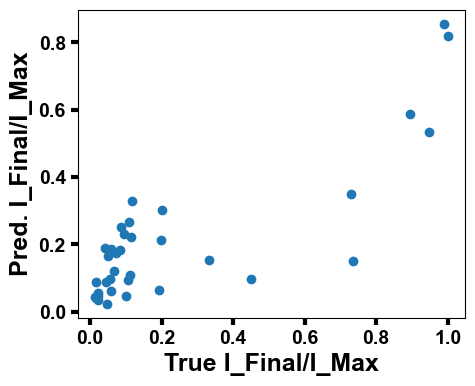

In [22]:
# Final_Current_Percent as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Final_Current_Percent
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix, charge_denisty, Init_R, 
                                 Res_Drop, Volt_Drop, Graphene_Yield), axis=1)

r_squareS = []
pearsonrS = []
coef_mat_S = []
for i in range (0, 50):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.4, random_state=i)
    clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    #print ('Gamma score:', clf.score(X_test, y_test.ravel()))
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r-squared', r2)
    #print ('mse: ', mean_squared_error(y_test, y_pred))
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r', pearr)
    r_squareS.append(r2)
    pearsonrS.append(pearr[0])
    coef_mat_S.append(clf.coef_[0:4])
print ('mean r2: ', np.mean(np.array(r_squareS)))
print ('mean pearson r: ', np.mean(np.array(pearsonrS)))

# Fix the hyperparamters and train only on training data
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Final_Current_Percent, test_size=0.2, random_state=global_rand_state_split)

clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
clf = clf.fit(input_features, Final_Current_Percent.ravel())
print ('coef_: ', clf.coef_)
CB_MC_PA_coef_Final_Current_Percent = clf.coef_[0:4]
y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
print ('pearson r', pearr)
    
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(y_test, y_pred)

ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
plt.xlabel('True I_Final/I_Max', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred. I_Final/I_Max', fontsize='18', fontname='Arial', fontweight='bold')
#mid_line = list(np.linspace(np.min(Final_Current_Percent), np.max(Final_Current_Percent), 8))
#plt.plot(mid_line, mid_line, '--', color='red')

mean r2:  0.5737012856539766
mean pearson r:  0.7818328015902216
coef_:  [ 0.00071247  0.00200843 -0.00206567 -0.00065867 -0.02314496  0.00764658
  0.0052986  -0.01622414  0.01380128 -0.02849293  0.00296596]
Gamma score: 0.6159273940572354
r-squared 0.6602140878113025
mse:  184772.5179181246
pearson r PearsonRResult(statistic=0.8260038079516139, pvalue=1.0011213605672863e-09)


Text(0, 0.5, 'Pred. Norm_I_Max')

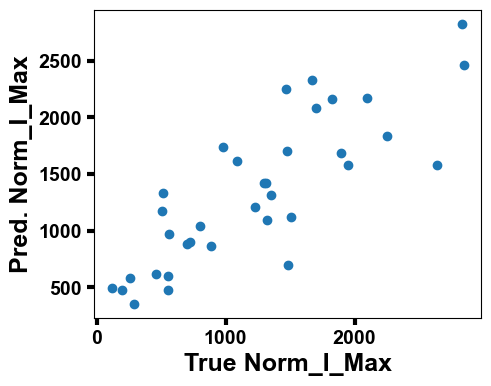

In [24]:
# Norm_I_Max as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Norm_I_Max
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 X_CB_MC_PA_TCB_ps_res_sa_sp2[:, (0, 1, 3)],
                                 Res_Drop, Volt_Drop), axis=1)

r_squareS = []
pearsonrS = []
coef_mat_S = []
for i in range (0, 20):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=i)
    clf = linear_model.GammaRegressor(alpha=0.1, max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    #print ('Gamma score:', clf.score(X_test, y_test.ravel()))
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r-squared', r2)
    #print ('mse: ', mean_squared_error(y_test, y_pred))
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r', pearr)
    r_squareS.append(r2)
    pearsonrS.append(pearr[0])
    coef_mat_S.append(clf.coef_[0:4])
print ('mean r2: ', np.mean(np.array(r_squareS)))
print ('mean pearson r: ', np.mean(np.array(pearsonrS)))

# get the average of all coef with different random states.
CB_MC_PA_coef_Norm_I_Max = np.mean (np.array(coef_mat_S), axis=0)
# Fix the hyperparamters and train only on training data
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_I_Max, test_size=0.2, random_state=global_rand_state_split)
clf = linear_model.GammaRegressor(alpha=0.1, max_iter=10000)
clf = clf.fit(input_features, Norm_I_Max.ravel())
print ('coef_: ', clf.coef_)
CB_MC_PA_coef_Norm_I_Max = clf.coef_[0:4]

y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
print ('pearson r', pearr)
    
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(y_test, y_pred)

ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
plt.xlabel('True Norm_I_Max', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred. Norm_I_Max', fontsize='18', fontname='Arial', fontweight='bold')
#mid_line = list(np.linspace(np.min(Norm_I_Max), np.max(Norm_I_Max), 8))
#plt.plot(mid_line, mid_line, '--', color='red')

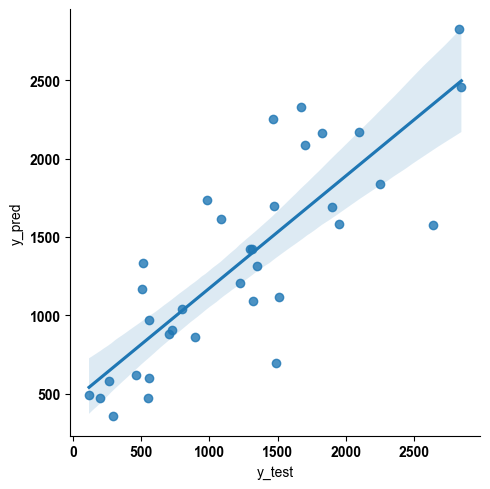

In [25]:
data = pd.DataFrame(())
data['y_test'] = y_test[:, 0]
data['y_pred'] = y_pred
sns.lmplot(data=data, x='y_test', y='y_pred')

mean r2:  0.4820106015744609
mean pearson r:  0.755414580009024
Gamma score: 0.6284228447271107
r-squared 0.5818237741620611
mse:  452.70617249677434
pearson r PearsonRResult(statistic=0.8006091353889395, pvalue=7.741475628948879e-09)


Text(0, 0.5, 'Pred. Norm_charge_tot')

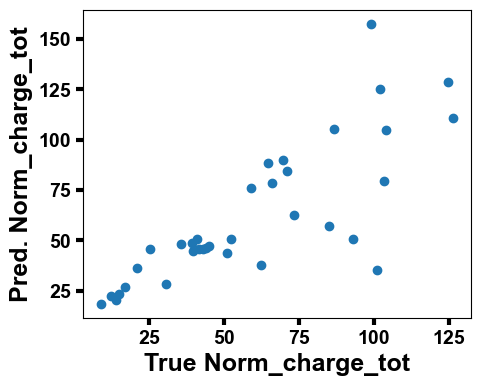

In [26]:
# Norm_charge_tot as output of linear model with inputs Precursor related
# Init_R, Res_Drop, Volt_Drop --> Norm_charge_tot
material_matrix_cosh = np.cosh (material_matrix)
Init_R = np.array (df['Init_R']).reshape (-1, 1)
Res_Drop = np.array (df['Res_Drop']).reshape (-1, 1)
Volt_Drop = np.array (df['Volt_Drop']).reshape (-1, 1)
Mass = np.array (df['Mass']).reshape(-1, 1)

input_features = np.concatenate((material_matrix, Init_R, charge_denisty,
                                 Res_Drop, Volt_Drop), axis=1)

r_squareS = []
pearsonrS = []
coef_mat_S = []
for i in range (0, 20):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=i)
    clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
    clf = clf.fit(X_train, y_train.ravel())
    CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0:4]
    y_pred = clf.predict (X_test)
    #print ('Gamma score:', clf.score(X_test, y_test.ravel()))
    r2 = r2_score(y_test.ravel(), y_pred.ravel())
    #print ('r-squared', r2)
    #print ('mse: ', mean_squared_error(y_test, y_pred))
    pearr = pearsonr(y_test.ravel(), y_pred.ravel())
    #print ('pearson r', pearr)
    r_squareS.append(r2)
    pearsonrS.append(pearr[0])
    coef_mat_S.append(clf.coef_[0:4])
print ('mean r2: ', np.mean(np.array(r_squareS)))
print ('mean pearson r: ', np.mean(np.array(pearsonrS)))

# get the average of all coef with different random states.
#CB_MC_PA_coef_Norm_charge_tot = np.mean (np.array(coef_mat_S), axis=0)
# Fix the hyperparamters and train only on training data
X_train, X_test, y_train, y_test = train_test_split(
        input_features, Norm_charge_tot, test_size=0.2, random_state=global_rand_state_split)
clf = linear_model.GammaRegressor(alpha=1, max_iter=10000)
clf = clf.fit(input_features, Norm_charge_tot.ravel())
CB_MC_PA_coef_Norm_charge_tot = clf.coef_[0:4]
#print ('coef_: ', clf.coef_)

y_pred = clf.predict (X_test)
print ('Gamma score:', clf.score(X_test, y_test.ravel()))
r2 = r2_score(y_test.ravel(), y_pred.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred))
pearr = pearsonr(y_test.ravel(), y_pred.ravel())
print ('pearson r', pearr)
    
fig, ax = plt.subplots(figsize=(5, 4))
plt.scatter(y_test, y_pred)

ax.tick_params(axis='x', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
ax.tick_params(axis='y', direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
plt.xlabel('True Norm_charge_tot', fontsize='18', fontname='Arial', fontweight='bold')
plt.ylabel('Pred. Norm_charge_tot', fontsize='18', fontname='Arial', fontweight='bold')
#mid_line = list(np.linspace(np.min(Norm_charge_tot), np.max(Norm_charge_tot), 8))
#plt.plot(mid_line, mid_line, '--', color='red')

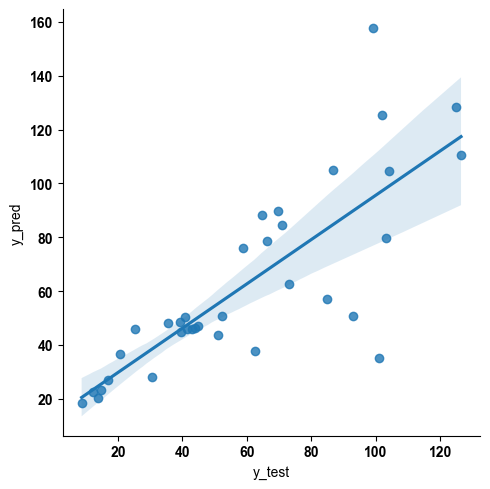

In [28]:
data = pd.DataFrame(())
data['y_test'] = y_test[:, 0]
data['y_pred'] = y_pred
sns.lmplot(data=data, x='y_test', y='y_pred')

In [29]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef = material_type * CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef = material_type * CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef = material_type * CB_MC_PA_coef_Norm_charge_tot

In [205]:
# proxy (current-time plot) prediction (Final_Current_percent)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type_I_Finalperc_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=global_rand_state_split
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, train_mat, test_mat, idxtrain, idx_test = \
                      train_test_split(new_features, Final_Current_Percent, df['Material'],
                                       indices, test_size = 0.20, random_state = rand)

feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_CB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']
new_features[0]

array([ 1.12800000e+02,  1.20000000e+03,  2.74083272e-02, -0.00000000e+00,
       -0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        6.00000000e+01])

In [206]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
# to optimize the hyperparamters.
for random_state in range(20):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.01, 
                   learning_rate=0.115, subsample=0.77, min_child_weight=8, 
                   random_state=random_state)
    #xgbr_final_I_percent = RandomForestRegressor(max_depth=20, n_estimators=500, min_samples_split=3)
    # xgbr_final_I_percent = linear_model.BayesianRidge()
    # xgbr_final_I_percent = XGBRegressor()
    # Train the model on training data
    labels = Final_Current_Percent
    xgbr_final_I_percent.fit(train_new_features, train_labels);
    #print('Doneskies')
    Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
    r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
    r_squareds.append(r_squared_Final_Current_test)
    
    r_pearson_Final_Current_test = pearsonr(test_labels.reshape(test_labels.shape[0],), 
                                            Final_Current_Percent_test.reshape(Final_Current_Percent_test.shape[0],))
    r_pearsons.append(r_pearson_Final_Current_test[0])   
    
    Final_Current_Percent_train = xgbr_final_I_percent.predict(train_new_features)
    r_squared_Final_Current_train = r2_score(train_labels, Final_Current_Percent_train)
    r_squareds_train.append(r_squared_Final_Current_train)    

print ('Average of r pearson for test', np.mean(np.array(r_pearsons)))
print ('std of r pearson for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

#xgbr_final_I_percent.fit(new_features, labels)
# Use the forest's predict method on the test data
xgbr_final_I_percent = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.01, 
                   learning_rate=0.115, subsample=0.77, min_child_weight=8, 
                   random_state=global_rand_state_xgb)

# train the model on all data
xgbr_final_I_percent.fit(new_features, Final_Current_Percent)

Final_Current_Percent_predicted = xgbr_final_I_percent.predict(new_features)
# Calculate the absolute errors
errors = abs(Final_Current_Percent_predicted - Final_Current_Percent)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Final_Current_all = r2_score(Final_Current_Percent, Final_Current_Percent_predicted)
print('r2 score = ', r_squared_Final_Current_all)

# Use the forest's predict method on the test data
Final_Current_Percent_test = xgbr_final_I_percent.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Final_Current_Percent_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Final_Current_test = r2_score(test_labels, Final_Current_Percent_test)
print('r2 score = ', r_squared_Final_Current_test)

Average of r pearson for test 0.8257617009545882
std of r pearson for test 0.011697266192124977 

Average of r_squared for test 0.6496461382671788
std of r_squared for test 0.018331679607905924 

Average of r_squared for train 0.722868080840531
std of r_squared for train 0.009237694424119255
Mean Absolute Error: 0.2064 units.
r2 score =  0.7782104927467972
Mean Absolute Error: 0.2645 units.
r2 score =  0.7707813685925431


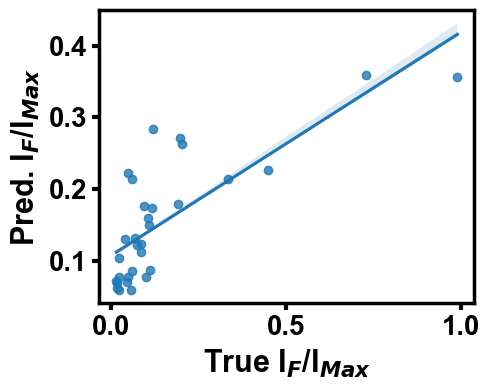

In [34]:
fig, ax = plt.subplots(figsize=(5, 4))
data = pd.DataFrame(())
data['y_pred'] = Final_Current_Percent_test
data['y_true'] = test_labels
data['material'] = df['Material']
# removed outliers
data_outlier_removed = data.loc[data['y_pred'] < 0.6]
#order is greater than 1, use numpy.polyfit to estimate a polynomial regression.
#sns.regplot(data=data_outlier_removed, x='y_test', y='y_pred', ci=70, order=2)
sns.regplot(data=data_outlier_removed, x='y_true', y='y_pred', ci=20, order=1)

ax.set_ylabel('Pred. I$_{F}$/I$_{Max}$', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xlabel('True I$_{F}$/I$_{Max}$', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
#plt.yticks((0.1, 0.3, 0.5))
#plt.xticks((0.1, 0.5, 0.9))
plt.tight_layout()
plt.savefig('pred_IfinalImax.jpeg', dpi=500)


In [35]:
# Get numerical feature importances
importances = list(xgbr_final_I_percent.feature_importances_)
print (importances)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

[0.08780227, 0.5579897, 0.057988457, 0.09316605, 0.0, 0.0, 0.07221559, 0.0, 0.1308379]
Variable: charge_denisty Importance: ('charge_denisty', 0.09)
Variable: PulseTime Importance: ('PulseTime', 0.56)
Variable: material_CB Importance: ('material_CB', 0.06)
Variable: material_MC Importance: ('material_MC', 0.09)
Variable: material_PA Importance: ('material_PA', 0.0)
Variable: material_CB Importance: ('material_CB', 0.0)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.07)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.0)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.13)


In [36]:
# proxy (current-time plot) prediction (Norm_I_Max)
new_features = np.concatenate ((charge_denisty,
                                #np.array (df['Voltage']).reshape(-1, 1),
                                pulsetime,
                                material_type_Norm_I_Max_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=global_rand_state_split
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_I_Max, 
                                       indices, test_size = 0.2, random_state = rand)

feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

PearsonRResult(statistic=0.7730380455063395, pvalue=5.25118995195737e-08)
Average of pearson r for test 0.7807064019135773
std of pearson 1 for test 0.008504328139339193 

Average of r_squared for test 0.5904268718147494
std of r_squared for test 0.01081522167846165 

Average of r_squared for train 0.6996431128373827
std of r_squared for train 0.004964789250240874
Mean Absolute Error: 718.5204 units.
r2 score =  0.690673533208469
Mean Absolute Error: 724.6505 units.
r2 score =  0.6660759141656234


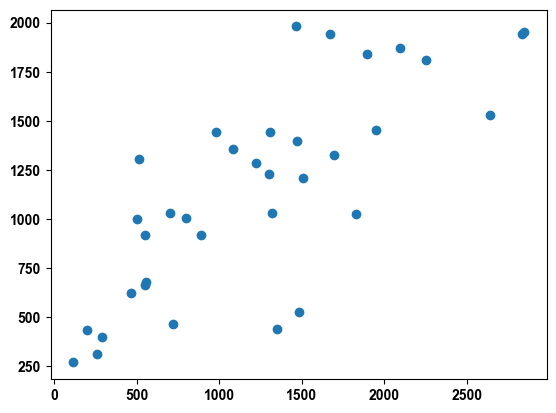

In [37]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
for random_state in range(10):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    
    xgbr_norm_I_max = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=6, 
                  random_state=random_state)
    
    #xgbr_norm_I_max = RandomForestRegressor(max_depth=3, n_estimators=100, min_samples_split=3)
    # xgbr_norm_I_max = linear_model.BayesianRidge()
    # xgbr_norm_I_max = XGBRegressor()
    # Train the model on training data
    labels = Norm_I_Max
    xgbr_norm_I_max.fit(train_new_features, train_labels);
    
    Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
    r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)

    test_labels_ = test_labels.reshape(test_labels.shape[0], )

    Norm_I_Max_test_ = Norm_I_Max_test.reshape(Norm_I_Max_test.shape[0], )

    r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
    r_pearsons.append(r_pearson_Norm_I_Max_test[0])
    r_squareds.append(r_squared_Norm_I_Max_test)
    
    Norm_I_Max_train = xgbr_norm_I_max.predict(train_new_features)
    r_squared_Norm_I_Max_train = r2_score(train_labels, Norm_I_Max_train)
    r_squareds_train.append(r_squared_Norm_I_Max_train)  

xgbr_norm_I_max = XGBRegressor(max_depth=3, n_estimators=25, gamma=0.001, 
                   learning_rate=0.09, subsample=0.775, min_child_weight=6, 
                  random_state=global_rand_state_xgb)
xgbr_norm_I_max.fit(new_features, Norm_I_Max);

r_pearson_Norm_I_Max_test = pearsonr(test_labels_, Norm_I_Max_test_)
print (r_pearson_Norm_I_Max_test)
plt.scatter(test_labels_, Norm_I_Max_test_)
print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')
print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')
print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

#xgbr_norm_I_max.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_I_Max_predicted = xgbr_norm_I_max.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_I_Max_predicted - Norm_I_Max)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_I_Max_all = r2_score(Norm_I_Max, Norm_I_Max_predicted)
print('r2 score = ', r_squared_Norm_I_Max_all)

# Use the forest's predict method on the test data
Norm_I_Max_test = xgbr_norm_I_max.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_I_Max_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_I_Max_test = r2_score(test_labels, Norm_I_Max_test)
print('r2 score = ', r_squared_Norm_I_Max_test)

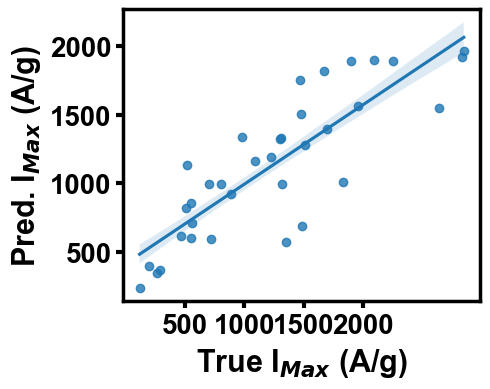

In [38]:
fig, ax = plt.subplots(figsize=(5, 4))
data = pd.DataFrame(())
data['y_pred'] = Norm_I_Max_test
data['y_true'] = test_labels 
data['material'] = df['Material']
# removed outliers
data_outlier_removed = data.loc[data['y_true'] < 3000]
#order is greater than 1, use numpy.polyfit to estimate a polynomial regression.
#sns.regplot(data=data_outlier_removed, x='y_test', y='y_pred', ci=70, order=2)
sns.regplot(data=data_outlier_removed, x='y_true', y='y_pred', ci=70, order=1)

ax.set_ylabel('Pred. I$_{Max}$ (A/g)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xlabel('True I$_{Max}$ (A/g)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
plt.xticks((500, 1000, 1500, 2000))
plt.yticks((500, 1000, 1500, 2000))

plt.tight_layout()
plt.savefig('pred_norm_Imax.jpeg', dpi=500)
#print (pearsonr(Norm_I_Max_test, test_labels))

In [39]:
# Get numerical feature importances
importances = list(xgbr_norm_I_max.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];
print (importances)

Variable: charge_denisty Importance: ('charge_denisty', 0.14)
Variable: PulseTime Importance: ('PulseTime', 0.03)
Variable: material_CB Importance: ('material_CB', 0.0)
Variable: material_MC Importance: ('material_MC', 0.55)
Variable: material_PA Importance: ('material_PA', 0.0)
Variable: material_TCB Importance: ('material_TCB', 0.06)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.0)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.09)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.14)
[0.14157234, 0.029698323, 0.0, 0.54556566, 0.0, 0.06243607, 0.0, 0.08547817, 0.13524944]


In [207]:
# proxy (current-time plot) prediction (Norm_Norm_charge_tot)
new_features = np.concatenate ((charge_denisty,
                                pulsetime,
                                material_type_Norm_charge_Tot_coef,
                                atmosphere_type,
                                Pretreat_voltage), axis=1)

rand=global_rand_state_split
indices = np.arange(len(new_features))
train_new_features, test_new_features, train_labels, test_labels, idxtrain, idx_test = \
                      train_test_split(new_features, Norm_charge_tot, 
                                       indices, test_size = 0.20, random_state = rand)
feature_list = ['charge_denisty',
                'PulseTime',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Pretreat_voltage']

In [208]:
r_squareds = list()
r_pearsons = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
# used for hyperparamter tunning.
for random_state in range(4):
    # after fixing the hyperparameters, train the model on all samples
    # Instantiate model with 1000 decision tree
    xgbr_norm_charge_total = XGBRegressor(max_depth=10, n_estimators=100, gamma=0.01, 
                   learning_rate=0.118, subsample=0.75, min_child_weight=2, 
                  random_state=random_state)
    #xgbr_norm_charge_total = RandomForestRegressor(max_depth=5, n_estimators=200, min_samples_split=3)
    # xgbr_norm_charge_total = linear_model.BayesianRidge()
    # xgbr_norm_charge_total = XGBRegressor()
    # Train the model on training data
    labels = Norm_charge_tot
    xgbr_norm_charge_total.fit(train_new_features, train_labels);
    #print('Doneskies')
    Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
    r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
    r_squareds.append(r_squared_Norm_charge_tot_test)
    
    test_labels_ = test_labels.reshape(test_labels.shape[0], )
    Norm_charge_tot_test_ = Norm_charge_tot_test.reshape(Norm_charge_tot_test.shape[0], )
    r_pearson_Norm_charge_tot_test = pearsonr(test_labels_, Norm_charge_tot_test_)
    r_pearsons.append(r_pearson_Norm_charge_tot_test[0])

    
    Norm_charge_tot_train = xgbr_norm_charge_total.predict(train_new_features)
    r_squared_Norm_charge_tot_train = r2_score(train_labels, Norm_charge_tot_train)
    r_squareds_train.append(r_squared_Norm_charge_tot_train)    

print ('Average of pearson r for test', np.mean(np.array(r_pearsons)))
print ('std of pearson 1 for test', np.std(np.array(r_pearsons)), '\n')

print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
print ('std of r_squared for train', np.std(np.array(r_squareds_train)))

xgbr_norm_charge_total = XGBRegressor(max_depth=10, n_estimators=100, gamma=0.01, 
                   learning_rate=0.118, subsample=0.75, min_child_weight=2, 
                  random_state=global_rand_state_xgb)
xgbr_norm_charge_total.fit(new_features, Norm_charge_tot)
#xgbr_norm_charge_total.fit(new_features, labels)
# Use the forest's predict method on the test data
Norm_charge_tot_predicted = xgbr_norm_charge_total.predict(new_features)
# Calculate the absolute errors
errors = abs(Norm_charge_tot_predicted - Norm_charge_tot)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

r_squared_Norm_charge_tot_all = r2_score(Norm_charge_tot, Norm_charge_tot_predicted)
print('r2 score = ', r_squared_Norm_charge_tot_all)

# Use the forest's predict method on the test data
Norm_charge_tot_test = xgbr_norm_charge_total.predict(test_new_features)
# Calculate the absolute errors
errors_test = abs(Norm_charge_tot_test - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors_test), 4), 'units.')

r_squared_Norm_charge_tot_test = r2_score(test_labels, Norm_charge_tot_test)
print('r2 score = ', r_squared_Norm_charge_tot_test)

Average of pearson r for test 0.7682777123888193
std of pearson 1 for test 0.025148086951801086 

Average of r_squared for test 0.5512438135408877
std of r_squared for test 0.04568752358803803 

Average of r_squared for train 0.9989196257993428
std of r_squared for train 0.0002678859399748869
Mean Absolute Error: 34.65 units.
r2 score =  0.9993209585434534
Mean Absolute Error: 37.468 units.
r2 score =  0.9994327297440013


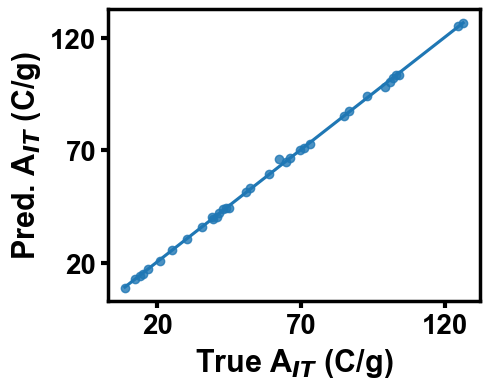

In [42]:
fig, ax = plt.subplots(figsize=(5, 4))
data = pd.DataFrame(())
data['y_pred'] = Norm_charge_tot_test
data['y_true'] = test_labels 
data['material'] = df['Material']
# removed outliers
data_outlier_removed = data.loc[data['y_true'] > 0]
#order is greater than 1, use numpy.polyfit to estimate a polynomial regression.
#sns.regplot(data=data_outlier_removed, x='y_test', y='y_pred', ci=70, order=2)
sns.regplot(data=data_outlier_removed, x='y_true', y='y_pred', ci=70, order=1)

ax.set_ylabel('Pred. A$_{IT}$ (C/g)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
ax.set_xlabel('True A$_{IT}$ (C/g)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
plt.xticks((20, 70, 120))
plt.yticks((20, 70, 120))
plt.tight_layout()
plt.savefig('pred_norm_total_charge.jpeg', dpi=500)
#print (pearsonr(Norm_charge_tot_test, test_labels))

In [43]:
# Get numerical feature importances
importances = list(xgbr_norm_charge_total.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
#feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {} Importance: {}'.format(feature, importance)) 
 for (feature, importance) in zip(feature_list, feature_importances)];

print (importances)

Variable: charge_denisty Importance: ('charge_denisty', 0.12)
Variable: PulseTime Importance: ('PulseTime', 0.13)
Variable: material_CB Importance: ('material_CB', 0.08)
Variable: material_MC Importance: ('material_MC', 0.22)
Variable: material_PA Importance: ('material_PA', 0.03)
Variable: material_TCB Importance: ('material_TCB', 0.18)
Variable: Atmosphere_air Importance: ('Atmosphere_air', 0.06)
Variable: Atmosphere_arg Importance: ('Atmosphere_arg', 0.09)
Variable: Pretreat_voltage Importance: ('Pretreat_voltage', 0.1)
[0.11565808, 0.13434339, 0.07814487, 0.21512999, 0.02933864, 0.18005364, 0.06032615, 0.08544435, 0.101560816]


In [44]:
print (CB_MC_PA_coef_Final_Current_Percent)
print (CB_MC_PA_coef_Norm_I_Max)
print (CB_MC_PA_coef_Norm_charge_tot)
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3
print (CB_MC_PA_TCB_coef_average)

[ 0.02740833 -0.00517625 -0.00779301 -0.01441071]
[ 0.00071247  0.00200843 -0.00206567 -0.00065867]
[ 0.01238386 -0.00267316 -0.01144384  0.00167383]
[ 0.01350155 -0.00194699 -0.00710084 -0.00446518]


coef_:  [ 4.55878349e-03  5.49787821e+00  2.83424606e-01  2.73931367e-01
  1.78599290e+01  7.44015513e+00 -1.87904503e+00 -7.79884825e-01
  1.43030749e+00 -2.80135865e-02  1.55382165e+00]
PearsonRResult(statistic=0.8120360030060824, pvalue=3.2033294010735094e-09)
r-squared 0.6414839336892018
mse:  331.88087675697045


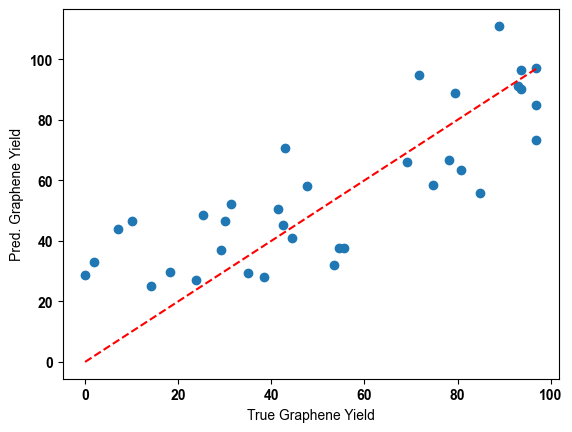

coef_:  [ 4.55878349e-03  5.49787821e+00  2.83424606e-01  2.73931367e-01
  1.78599290e+01  7.44015513e+00 -1.87904503e+00 -7.79884825e-01
  1.43030749e+00 -2.80135865e-02  1.55382165e+00]
PearsonRResult(statistic=0.767648695878209, pvalue=4.583439374388308e-35)
r-squared 0.5892845202835151
adj. r-squared 0.561396432154618
mse:  306.9622911431935
rmse:  17.520339355822806
mae:  14.734334134970883


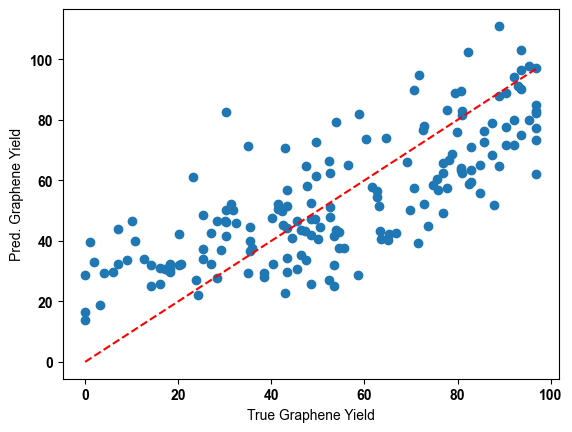

Text(0, 0.5, 'error of regression')

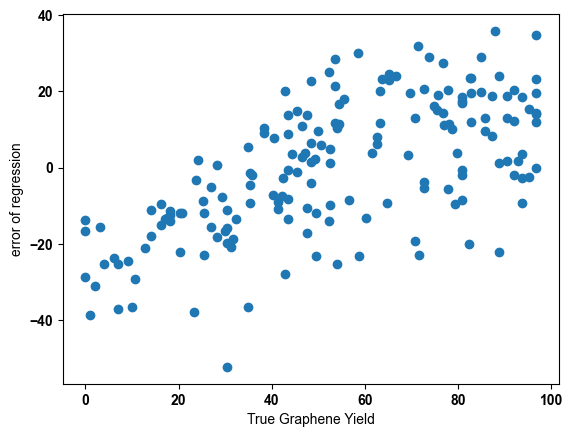

In [147]:
# linearly relate the input paramters to the final Graphene Yield
voltage_ALL = np.array (df['Voltage'].loc[df['Material']!='AAA']).reshape(-1, 1)
mass_ALL = np.array (df['Mass'].loc[df['Material']!='AAA']).reshape(-1, 1)
cap_ALL = np.array (df['Cap'].loc[df['Material']!='AAA']).reshape(-1, 1)
GY_ALL = np.array (df['Graphene_Yield'].loc[df['Material']!='AAA']).reshape(-1, 1)
CD_ALL = np.array (df['charge_density'].loc[df['Material']!='AAA']).reshape(-1, 1)
prevol_ALL = np.array (df['Pretreat_voltage'].loc[df['Material']!='AAA']).reshape(-1, 1)
prevolhighest_ALL = np.array (df['Pretreat_voltage'].loc[df['Material']!='AAA']).reshape(-1, 1)
I_Max_ALL = np.array (df['I_Max'].loc[df['Material']!='AAA']).reshape(-1, 1)
I_Mean_ALL = np.array (df['I_Mean'].loc[df['Material']!='AAA']).reshape(-1, 1)
charge_tot_ALL = np.array (df['Charge_Tot'].loc[df['Material']!='AAA']).reshape(-1, 1)
pulsetime_ALL = np.array (df['PulseTime'].loc[df['Material']!='AAA']).reshape(-1, 1)
maxima_ALL = np.array (df['Maxima'].loc[df['Material']!='AAA']).reshape(-1, 1)

                                #Final_Current_Percent_predicted.reshape(-1, 1),
                                #Norm_I_Max_predicted.reshape(-1, 1),
                                #Norm_charge_tot_predicted.reshape(-1, 1), 
            
input_features = np.concatenate(((voltage_ALL**1*((mass_ALL/100)**-1)*(cap_ALL**1))**1
                                 , (prevol_ALL**1)*1e-2 
                                 , (Norm_I_Max_predicted.reshape(-1, 1)**1)*1e-2
                                 , pulsetime_ALL**0.5
                                 , ((Norm_charge_tot_predicted.reshape(-1, 1))**1)*1e-2
                                 , mass_ALL*1e-2 
                                 , cap_ALL*1e-1
                                 , X_CB_MC_PA_TCB_ps_res_sa_sp2 [df['Material']!='AAA']
                                   ), axis=1)

max_gamma_score = 0
for rand in range(0, 20):
    X_train, X_test, y_train, y_test = train_test_split(
        input_features, GY_ALL, test_size=0.2, random_state=rand)
    phys_reg_mdl = linear_model.LinearRegression(fit_intercept=True, positive=False)
    phys_reg_mdl = phys_reg_mdl.fit(X_train, y_train.ravel())
    if phys_reg_mdl.score(X_test, y_test.ravel()) > max_gamma_score:
        max_gamma_score = phys_reg_mdl.score(X_test, y_test.ravel())
        best_random_state = rand

X_train, X_test, y_train, y_test = train_test_split(
        input_features, GY_ALL, test_size=0.2, random_state=global_rand_state_split)

phys_reg_mdl = linear_model.LinearRegression(fit_intercept=True, positive=False)
phys_reg_mdl = phys_reg_mdl.fit(input_features, GY_ALL.ravel())
print ('coef_: ', phys_reg_mdl.coef_)
y_pred_phys_reg_mdl = phys_reg_mdl.predict (X_test)

print (pearsonr(y_test.ravel(), y_pred_phys_reg_mdl.ravel()))
r2 = r2_score(y_test.ravel(), y_pred_phys_reg_mdl.ravel())
print ('r-squared', r2)
print ('mse: ', mean_squared_error(y_test, y_pred_phys_reg_mdl))

plt.scatter(y_test, y_pred_phys_reg_mdl)
plt.xlabel('True Graphene Yield')
plt.ylabel('Pred. Graphene Yield')

mid_line = list(np.linspace(np.min(GY_ALL), np.max(GY_ALL), 8))
plt.plot(mid_line, mid_line, '--', color='red')
plt.show()


phys_reg_mdl = phys_reg_mdl.fit(input_features, GY_ALL.ravel())

print ('coef_: ', phys_reg_mdl.coef_)

y_pred = phys_reg_mdl.predict (input_features)

print (pearsonr(GY_ALL.ravel(), y_pred.ravel()))
r2 = r2_score(GY_ALL.ravel(), y_pred.ravel())
print ('r-squared', r2)
n = input_features.shape[0]
p = input_features.shape[1]
Adj_r2 = 1-(1-r2)*(n-1)/(n-p-1)
print ('adj. r-squared', Adj_r2)
print ('mse: ', mean_squared_error(GY_ALL, y_pred))
print ('rmse: ', np.sqrt(mean_squared_error(GY_ALL, y_pred)))
print ('mae: ', mean_absolute_error(GY_ALL, y_pred))


plt.scatter(GY_ALL, y_pred)
plt.xlabel('True Graphene Yield')
plt.ylabel('Pred. Graphene Yield')
mid_line = list(np.linspace(np.min(GY_ALL), np.max(GY_ALL), 8))
plt.plot(mid_line, mid_line, '--', color='red')
plt.show()

error = GY_ALL - y_pred.reshape(-1, 1)
plt.scatter (GY_ALL, (error))
plt.xlabel('True Graphene Yield')
plt.ylabel('error of regression')

In [146]:
y_pred_phys_reg_mdl = phys_reg_mdl.predict (X_test)

print (pearsonr(y_test.ravel(), y_pred_phys_reg_mdl.ravel()))

PearsonRResult(statistic=0.8120360030060824, pvalue=3.2033294010735094e-09)


PearsonRResult(statistic=0.8120360030060824, pvalue=3.2033294010735094e-09)


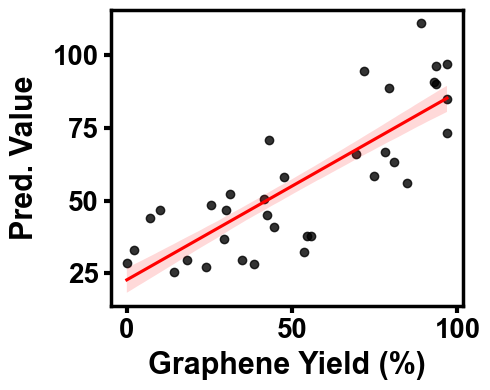

In [48]:
data = pd.DataFrame(())
data['y_pred'] = y_pred_phys_reg_mdl
data['y_true'] = y_test 
fig, ax = plt.subplots(figsize=(5, 4))

# removed outliers
#data_outlier_removed = data.loc[data['y_true'] > 0]
#order is greater than 1, use numpy.polyfit to estimate a polynomial regression.
#sns.regplot(data=data_outlier_removed, x='y_test', y='y_pred', ci=70, order=2)
sns.regplot(data=data, x='y_true', y='y_pred', ci=70, order=1,
           scatter_kws={"color": "black"}, line_kws={"color": "red"})

ax.set_ylabel('Pred. Value', fontsize='22', fontname='Arial', fontweight='bold', labelpad=10)
ax.set_xlabel('Graphene Yield (%)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')

#plt.xticks((25, 50, 75, 100))
#plt.yticks((20, 45, 70, 95))
#plt.xlim(2,102)
#plt.ylim(15,98)
plt.tight_layout()
plt.savefig('pred_physics_GY.jpeg', dpi=500)
print (pearsonr(phys_reg_mdl.predict (X_test), data['y_true'] ))

In [590]:
# assume constant resisitivity for precursors
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix = np.matmul(material_matrix, CB_MC_PA_TCB_res)
heat_power = np.array (df['Voltage']*df['Voltage']/resistance_matrix*df['PulseTime']*(1e-6)).reshape(-1, 1)
# got it from model based prediction of I_Max
# got it from model based prediction of I_Max
CB_MC_PA_TCB_coef_average = (CB_MC_PA_coef_Final_Current_Percent +
                             CB_MC_PA_coef_Norm_I_Max +
                             CB_MC_PA_coef_Norm_charge_tot)/3

material_type_GY_coef = material_type * CB_MC_PA_TCB_coef_average
# Porxy properties, as well as process parameters
new_features = np.concatenate ((charge_denisty, 
                                X_CB_MC_PA_TCB_ps_res_sa_sp2,
                                #np.array(df['Volt_Drop']/df['I_Mean']).reshape(-1, 1),
                                material_type_GY_coef,
                                pulsetime,
                                Pretreat_voltage,
                                y_pred.reshape(-1, 1),
                                atmosphere_type,
                                Final_Current_Percent_predicted.reshape(-1, 1),
                                Norm_I_Max_predicted.reshape(-1, 1),
                                Norm_charge_tot_predicted.reshape(-1, 1), 
                                heat_power.reshape(-1, 1),
                                temp2
                                ), axis=1)

rand=global_rand_state_split
test_size = 0.2
indices = np.arange(len(new_features))
labels = Graphene_Yield
train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, labels, 
                                       indices, test_size = test_size, random_state = rand
                                       #,stratify=df['Material']
                                      )

feature_list = ['charge_denisty',
                'material_ps',
                'material_res',
                'material_sa',
                'material_sp2',
                'material_CB',
                'material_MC',
                'material_PA',
                'material_TCB',
                'PulseTime',
                'Pretreat_voltage',
                #'physicsbased_model',
                'Atmosphere_air',
                'Atmosphere_arg',
                'Final_Current_Percent',
                'Norm_I_Max',
                'Norm_charge_tot',
                'heat_power',
                'temp']

In [581]:
print (len(feature_list))
print (new_features.shape)

18
(174, 19)


In [591]:
# stratify added to put same ratio of precursors in test and train
CB_count = sum(df['Material']=='CB')
MC_count = sum(df['Material']=='MC')
PA_count = sum(df['Material']=='PA')
TCB_count = sum(df['Material']=='TCB')
total = CB_count + MC_count + PA_count + TCB_count
print ('CB_count', CB_count, round(CB_count/total, 2),"% of total", total)
print ('MC_count', MC_count, round(MC_count/total, 2),"% of total", total)
print ('PA_count', PA_count, round(PA_count/total, 2),"% of total", total)
print ('TCB_count', TCB_count, round(TCB_count/total, 2),"% of total", total)

print ('CB count for testing {}% is {}'.format(test_size, round(test_size*CB_count, 0)))
print (sum (df['Material'][idx_test]=='CB'))
print ('MC count for testing {}% is {}'.format(test_size, round(test_size*MC_count, 0)))
print (sum (df['Material'][idx_test]=='MC'))
print ('PA count for testing {}% is {}'.format(test_size, round(test_size*PA_count, 0)))
print (sum (df['Material'][idx_test]=='PA'))
print ('TCB count for testing {}% is {}'.format(test_size, round(test_size*TCB_count, 0)))
print (sum (df['Material'][idx_test]=='TCB'))

CB_count 57 0.33 % of total 174
MC_count 44 0.25 % of total 174
PA_count 36 0.21 % of total 174
TCB_count 37 0.21 % of total 174
CB count for testing 0.2% is 11.0
16
MC count for testing 0.2% is 9.0
9
PA count for testing 0.2% is 7.0
3
TCB count for testing 0.2% is 7.0
7


In [587]:
np.any(train_labels)=='Nan'

False

In [592]:
# focus on Random Forest, Similar to Jacob, !!!!5 train/test split iterations!!!!
r_squareds_rf = list()
r_squareds_rf_randomized_testtrain = list()
r_squareds_rf_train = list()
MAEs = list()
MAEs_train = list()
RMSEs_rf = list()
start = time.time()
r2_max = 0
test_split_seed1 = 9
test_split_seed2 = 10
test_split_count = test_split_seed2 - test_split_seed1

for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.2, random_state=rand
                                       #, stratify=df['Material']
                                       )
    r_squareds_rf = list()
    r_squareds_rf_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(0, 10):
        # Instantiate model with 1000 decision trees
        rf_graphyield = RandomForestRegressor(max_depth=15, n_estimators=30, 
                                              random_state=random_state, min_samples_split=10)
        """
        rf_graphyield = MLPRegressor(hidden_layer_sizes=(500, 500, 500), activation='logistic', batch_size=2,
                   alpha=0.00001, learning_rate = 'adaptive', solver='adam', random_state=random_state)    
        """
        # Train the model on training data
        rf_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = rf_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        RMSEs_rf.append (np.sqrt (mean_squared_error(predictions, test_labels)))
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds_rf.append (r_squared)
    
        pred_train = rf_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_rf_train.append(r_squared)
        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds_rf)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds_rf)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_rf_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_rf_train)))
    # train accuracy
    pred_train = rf_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = rf_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds_rf)
    r_squareds_rf_randomized_testtrain.append (r_squareds_rf)

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(pred_test, test_labels)
print ('RMSE for test, ', m.result().numpy())

end = time.time()
r_squareds_rf_randomized_testtrain_vec = np.array ((r_squareds_rf_randomized_testtrain))
r_squareds_rf_randomized_testtrain_mean = np.mean (r_squareds_rf_randomized_testtrain_vec, axis=1)
r_squareds_rf_randomized_testtrain_mean
#sns.displot (r_squareds_rf_randomized_testtrain_vec)

r_squareds_rf = r_squareds_rf_randomized_testtrain_vec
print ('r2 of test', np.mean(r_squareds_rf_randomized_testtrain_mean))
print ('r2 of test', np.mean(r_squareds_rf_train))

print ('sd of random runs', np.sqrt(np.var(r_squareds_rf_randomized_testtrain_vec)))

/tmp/ipykernel_22062/4034422065.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);
/tmp/ipykernel_22062/4034422065.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);
/tmp/ipykernel_22062/4034422065.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);
/tmp/ipykernel_22062/4034422065.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);
/tmp

RMSE for test,  14.398226
r2 of test 0.7282508806951717
r2 of test 0.8792966502883974
sd of random runs 0.03167992630624504


/tmp/ipykernel_22062/4034422065.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);
/tmp/ipykernel_22062/4034422065.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);
/tmp/ipykernel_22062/4034422065.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);
/tmp/ipykernel_22062/4034422065.py:34: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_graphyield.fit(train_new_features, train_labels);


In [559]:
xgbr_graphyield = rf_graphyield

RMSE for test,  17.092175
time for 1 of split and 50 rep. is: 6.300276041030884
r2 mean for test:  [0.73486853]
r2 mean for train:  0.9922091532666546


<AxesSubplot: ylabel='Count'>

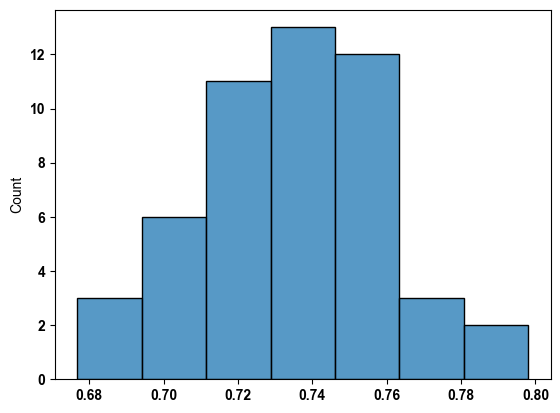

In [680]:
# one random sample from XGBoost: check the last printed r2 is good.
# 362 as random state reaches the best
r_squareds = list()
r_squareds_randomized_testtrain = list()
r_squareds_train = list()
MAEs = list()
MAEs_train = list()
start = time.time()
r2_max = 0
test_split_seed1 = global_rand_state_split
test_split_seed2 = global_rand_state_split+1
test_split_count = test_split_seed2 - test_split_seed1
rep = 50
for rand in range (test_split_seed1, test_split_seed2):
    indices = np.arange(len(new_features))
    train_new_features, test_new_features, train_labels, test_labels, idx_train, idx_test = \
                      train_test_split(new_features, Graphene_Yield, 
                                       indices, test_size = 0.2, random_state=rand
                                       #,stratify=df['Material']
                                       )
    r_squareds = list()
    r_squareds_train = list()
    MAEs = list()
    MAEs_train = list()
    for random_state in range(rep):
        # Instantiate model with 1000 decision trees
        xgbr_graphyield = XGBRegressor(max_depth=4, n_estimators=100, gamma=0.001, 
                   learning_rate=0.115, subsample=0.75, min_child_weight=4, 
                   random_state=random_state)

        """
        xgbr_graphyield = MLPRegressor(hidden_layer_sizes=(500, 500, 500), activation='logistic', batch_size=2,
                   alpha=0.00001, learning_rate = 'adaptive', solver='adam', random_state=random_state)    
        """
        # Train the model on training data
        xgbr_graphyield.fit(train_new_features, train_labels);
        # Use the forest's predict method on the test data
        predictions = xgbr_graphyield.predict(test_new_features)
        # Calculate the absolute errors
        errors = abs(predictions - test_labels)
        MAEs.append(errors)
        # Print out the mean absolute error (mae)
        #print('Mean Absolute Error:', round(np.mean(errors), 4), 'units.')

        r_squared = r2_score(test_labels, predictions)
        r_squareds.append (r_squared)
    
        pred_train = xgbr_graphyield.predict(train_new_features)
        errors = abs(pred_train - train_labels)
        MAEs_train.append(errors)
        r_squared = r2_score(train_labels, pred_train)
        r_squareds_train.append(r_squared)
        #print('r2 score = ', r_squared)
    #print ('test split rand', rand)
    #print ('Average of r_squared for test', np.mean(np.array(r_squareds)))
    #print ('std of r_squared for test', np.std(np.array(r_squareds)), '\n')

    #print ('Average of r_squared for train', np.mean(np.array(r_squareds_train)))
    #print ('std of r_squared for train', np.std(np.array(r_squareds_train)))
    # train accuracy
    pred_train = xgbr_graphyield.predict(train_new_features)
    # Calculate the absolute errors
    errors_train = abs(pred_train - train_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error:', round(np.mean(errors_train), 4), 'units.')
    r_squared_train = r2_score(train_labels, pred_train)
    #print('r2 score = ', r_squared_train)
    #print ('time is: ', end-start)

    pred_test = xgbr_graphyield.predict(test_new_features)
    # Calculate the absolute errors
    #errors_test = abs(pred_test - test_labels)
    # Print out the mean absolute error (mae)
    #print('Mean Absolute Error for test:', round(np.mean(errors_test), 4), 'units.')
    r_squared_test = r2_score(test_labels, pred_test)
    if r_squared_test>r2_max:
        r2_max = r_squared_test
        rand_split = rand
    #print('r2 score = ', r_squared_test)
    #print ('****')

    #sns.displot(r_squareds)
    r_squareds_randomized_testtrain.append (r_squareds)

m = tf.keras.metrics.RootMeanSquaredError()
m.update_state(pred_test, test_labels)
print ('RMSE for test, ', m.result().numpy())
end = time.time()
print ('time for {} of split and {} rep. is: {}'.format(test_split_count, rep, end-start))
r_squareds_randomized_testtrain_vec = np.array ((r_squareds_randomized_testtrain))
r_squareds_randomized_testtrain_mean = np.mean (r_squareds_randomized_testtrain_vec, axis=1)
print ('r2 mean for test: ', r_squareds_randomized_testtrain_mean)
print ('r2 mean for train: ', np.mean (r_squareds_train))
sns.histplot (r_squareds_randomized_testtrain_vec[0])

#print ('all r2: ', r_squareds_randomized_testtrain_vec)

In [681]:
# train on all data
xgbr_graphyield.fit(new_features, Graphene_Yield);
pred_test = xgbr_graphyield.predict(new_features)
pearsonr(pred_test.ravel(), Graphene_Yield.ravel())

PearsonRResult(statistic=0.9959397090797263, pvalue=8.587845434646884e-182)

In [682]:
# reading the new experiment
filename = 'NewEval_FJH_temp.csv'
df_test0 = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=0)
df_test = df_test0.copy()

Material_CB_test = np.array (df_test['CB_per']).reshape(-1, 1)
Material_MC_test = np.array (df_test['MC_per']).reshape(-1, 1)
Material_PA_test = np.array (df_test['PA_per']).reshape(-1, 1)
Material_TCB_test = np.array (df_test['TCB_per']).reshape(-1, 1)

material_type_test = np.concatenate ((Material_CB_test, 
                                        Material_MC_test, 
                                        Material_PA_test,
                                        Material_TCB_test), axis=1)
material_type_GY_coef_test = material_type_test * CB_MC_PA_TCB_coef_average

# two dummy variables for atmosphere, air [1, 0], arg [0, 1]--> vaccum is [0, 0]
Atmosphere_air_test = np.array (df_test['Atmosphere_type']).reshape(-1, 1)
Atmosphere_air_test = [1 if i=='air' else 0 for i in Atmosphere_air_test]
Atmosphere_air_test = np.array (Atmosphere_air_test).reshape(-1, 1)
Atmosphere_arg_test = np.array (df_test['Atmosphere_type']).reshape(-1, 1)
Atmosphere_arg_test = [1 if i=='arg' else 0 for i in Atmosphere_arg_test]
Atmosphere_arg_test = np.array (Atmosphere_arg_test).reshape(-1, 1)
atmosphere_type_test = np.concatenate ((Atmosphere_air_test, 
                                          Atmosphere_arg_test ), axis=1)

charge_density_test = np.array (df_test['Voltage']*df_test['Cap']/
                                  df_test['Mass']).reshape(-1, 1)
pulsetime_test = np.array (df_test['PulseTime']).reshape(-1, 1)
Pretreat_voltage_test = np.array (df_test['Pretreat_voltage']).reshape(-1, 1)
voltage_test = np.array (df_test['Voltage']).reshape(-1, 1)
mass_test = np.array (df_test['Mass']).reshape(-1, 1)
Graphene_Yield_test = 100*np.array (df_test['Graphene_Yield']).reshape(-1, 1)

In [683]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef_test = material_type_test*CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef_test = material_type_test*CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef_test = material_type_test*CB_MC_PA_coef_Norm_charge_tot

# the features should follow the same order as fitting the model
# 1) Final_I prediction
features_test = np.concatenate ((charge_density_test,
                                   pulsetime_test,
                                   material_type_I_Finalperc_coef_test,
                                   atmosphere_type_test,
                                   Pretreat_voltage_test), axis=1)
Final_Current_Percent_predicted_test = xgbr_final_I_percent.predict(features_test)

# 2) norm_I_Max prediction
features_test = np.concatenate ((charge_density_test,
                                   pulsetime_test,
                                   material_type_Norm_I_Max_coef_test,
                                   atmosphere_type_test,
                                   Pretreat_voltage_test), axis=1)
Norm_I_Max_predicted_test = xgbr_norm_I_max.predict(features_test)

# 3) norm_Charge_total
features_test = np.concatenate ((charge_density_test,
                                   pulsetime_test,
                                   material_type_Norm_charge_Tot_coef_test,
                                   atmosphere_type_test,
                                   Pretreat_voltage_test), axis=1)
Norm_charge_tot_test = xgbr_norm_charge_total.predict(features_test)

In [684]:
# physics model prediction: fixed model (trained coefficients) predicting GY
X_CB_MC_PA_TCB_ps_res_sa_sp2_BO = np.matmul(material_type_test, 
                                            CB_MC_PA_TCB_ps_res_sa_sp2)
phys_mdl_input = np.concatenate((np.array(((df_test['Voltage']**1)*
                                  ((df_test['Mass']/100)**-1)*
                                  (df_test['Cap']**1))**1).reshape(-1, 1),
                                  ((np.array(df_test['Pretreat_voltage'])**1)*1e-2).reshape(-1, 1),
                                  ((Norm_I_Max_predicted_test.reshape(-1, 1))**1)*1e-2,
                                  (np.array(df_test['PulseTime']).reshape(-1, 1))**0.5,
                                  ((np.array(Norm_charge_tot_test.reshape(-1, 1)))**1)*1e-2,
                                  (np.array (df_test['Mass']).reshape (-1, 1))*1e-2 ,
                                  (np.array (df_test['Cap']).reshape (-1, 1))*1e-1,
                                  X_CB_MC_PA_TCB_ps_res_sa_sp2_BO,
                                  ), axis=1)
phys_pred_BO = phys_reg_mdl.predict (phys_mdl_input)
pearsonr (Graphene_Yield_test.ravel(), phys_pred_BO)

PearsonRResult(statistic=0.3082792285795443, pvalue=0.18604271768115133)

In [685]:
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix_BO = np.matmul(material_type_test, CB_MC_PA_TCB_res)
heat_power_BO = np.array (df_test['Voltage']*df_test['Voltage']/
                          resistance_matrix_BO*df_test['PulseTime']*(1e-6)).reshape(-1, 1)

features_test = np.concatenate ((charge_density_test,
                                 X_CB_MC_PA_TCB_ps_res_sa_sp2_BO,
                                 material_type_GY_coef_test,
                                 pulsetime_test,
                                 Pretreat_voltage_test,
                                 phys_pred_BO.reshape(-1, 1),
                                 atmosphere_type_test,
                                 Final_Current_Percent_predicted_test.reshape(-1, 1),
                                 Norm_I_Max_predicted_test.reshape(-1, 1),
                                 Norm_charge_tot_test.reshape(-1, 1),
                                 heat_power_BO,
                                 np.array (df_test['Tempv1']).reshape(-1, 1)
                                 ), axis=1)

In [686]:
graphene_yield_test = np.array (df_test['Graphene_Yield']).reshape(-1, 1)
graphene_yield_test = 100*graphene_yield_test
graphene_yield_test_predicted = xgbr_graphyield.predict (features_test)

print ('R-squared: ', r2_score(graphene_yield_test, graphene_yield_test_predicted))
print ('Pearson-r: ', pearsonr(graphene_yield_test.ravel(), graphene_yield_test_predicted.ravel()))
print ('RMSE: ', np.sqrt(mean_squared_error(graphene_yield_test, graphene_yield_test_predicted)))

R-squared:  -5.002412029814233
Pearson-r:  PearsonRResult(statistic=0.5375385234326108, pvalue=0.014510727925466448)
RMSE:  38.05091020652713


In [687]:
graphene_yield_test_predicted

array([62.131992, 72.03494 , 49.784164, 20.429892, 34.827816, 62.99842 ,
       46.471725, 52.951305, 55.55038 , 47.010983, 58.457676, 50.979675,
       27.01687 , 29.752745, 20.383434, 59.84021 , 55.474792, 52.84515 ,
       45.04916 , 53.211395], dtype=float32)

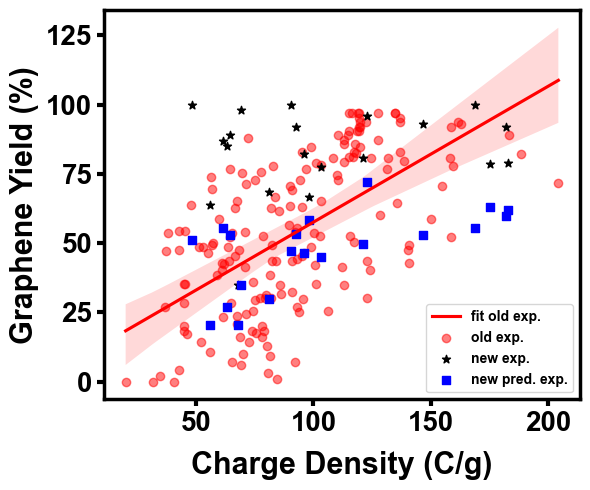

In [688]:
fig, ax = plt.subplots(figsize=(6, 5))

[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')

#plt.xticks((25, 50, 75, 100))
#plt.yticks((20, 45, 70, 95))
#plt.xlim(2,102)
#plt.ylim(15,98)

#plt.scatter (charge_denisty, Graphene_Yield, color='red', alpha=0.5, label='old exp.')
sns.regplot (data=df, x='charge_density', y='Graphene_Yield', color='red', 
             label='fit old exp.', ci=100, scatter=False)
plt.scatter (charge_denisty, Graphene_Yield, color='red', alpha=0.5, label='old exp.')
plt.scatter (charge_density_test, Graphene_Yield_test, color='black', marker='*', label='new exp.')
plt.scatter (charge_density_test, graphene_yield_test_predicted, color='blue', marker='s', label='new pred. exp.')

ax.set_xlabel('Charge Density (C/g)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=10)
ax.set_ylabel('Graphene Yield (%)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('GY_CV_oldVSnew_exp.jpeg', dpi=500)

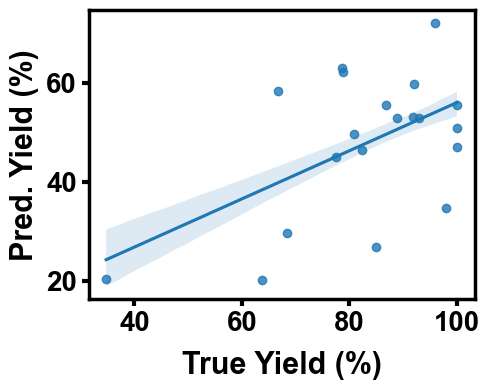

In [690]:
fig, ax = plt.subplots(figsize=(5, 4))

[i.set_linewidth(2.5) for i in ax.spines.values()]
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')

#plt.xticks((25, 50, 75, 100))
#plt.yticks((20, 45, 70, 95))
#plt.xlim(2,102)
#plt.ylim(15,98)
df_test ['Pred_Graphene_Yield'] = graphene_yield_test_predicted
df_test ['Graphene_Yield_per'] = 100*df_test ['Graphene_Yield'] 
#plt.scatter (charge_denisty, Graphene_Yield, color='red', alpha=0.5, label='old exp.')
sns.regplot (data=df_test, x="Graphene_Yield_per", y="Pred_Graphene_Yield", ci=50)
#plt.scatter (graphene_yield_test, graphene_yield_test_predicted)

ax.set_xlabel('True Yield (%)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=10)
ax.set_ylabel('Pred. Yield (%)', fontsize='22', fontname='Arial', fontweight='bold', labelpad=5)
#plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig('predGY_Newexp.jpeg', dpi=500)

<Axes.ArtistList of 0 artists>
<Axes.ArtistList of 0 artists>
<Axes.ArtistList of 0 artists>
<Axes.ArtistList of 0 artists>
<Axes.ArtistList of 0 artists>
<Axes.ArtistList of 0 artists>


/tmp/ipykernel_22062/1402373130.py:21: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for name, group in groups:


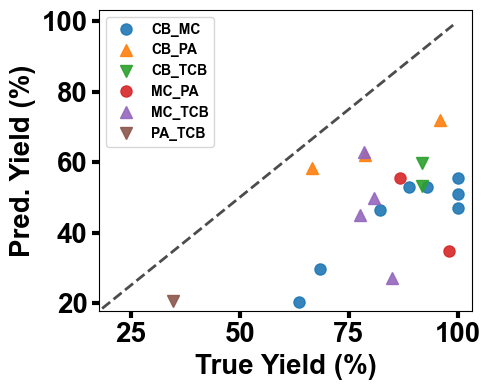

In [692]:
# Plot style
fig, ax = plt.subplots(figsize=(5, 4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Plot
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='20')
ax.set_ylabel('Pred. Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
ax.set_xlabel('True Yield (%)', fontsize='20', fontname='Arial', fontweight='bold')
#plt.scatter (graphene_yield_test, graphene_yield_test_predicted,  marker='v', 
#             c=df_test['Material_gtoup'])
df_test ['Pred_Graphene_Yield'] = graphene_yield_test_predicted
df_test ['Graphene_Yield_per'] = 100*df_test ['Graphene_Yield'] 
groups = df_test.groupby(['Material_group'])

markers = ['o', '^', 'v', 'o', '^', 'v']
colors=['blue', 'orange', 'green', 'blue', 'orange', 'green']

counter = 0
for name, group in groups:
    ax.plot(group.Graphene_Yield_per, group.Pred_Graphene_Yield, marker=markers[counter], alpha=0.9, 
            linestyle='', ms=8, label=name)
    print (ax.artists)
    counter+=1
    

ax.legend('TCB', fontsize=12, loc='upper left')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()

ax.set_xlim(min(xmin, ymin), max(ymax, xmax))
ax.set_ylim(min(xmin, ymin), max(ymax, xmax))
# Make a red line to show perfect predictions
x2 = np.arange(0, 100)
y2 = np.arange(0, 100)
#y2 = np.arange(0.1*ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '2', color='black', alpha=0.7)
leg = plt.legend(frameon="True", prop={'family': 'Arial'})

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')
# Save
plt.tight_layout()
plt.savefig('XGBoost_testsamples.jpeg', dpi=300)
plt.show()

In [ ]:
# Future experimental trial: call it newexp
filename = 'New_experimental_trial_modified_lucas.csv'
df_newexp0 = pd.read_csv(filename, sep=",", encoding='ISO-8859-1', header=0)
df_newexp = df_newexp0.copy()

# the prediction range should cover a large range
#df_newexp['Voltage'] = df_newexp0 ['Voltage'] - 20
#df_newexp['Mass'] = df_newexp0 ['Mass'] + 20

# Only works for test that are TCB material !!!!!!
material_type_newexp = np.asarray (df_newexp.loc[:, ('CB_per', 'MC_per', 'PA_per', 'TCB_per')])
# multiply constants to the matrix for the materials
# the constant calculated from [Init_R, Res_Drop, Volt_Drop] --> current quantities
material_type_GY_coef_newexp = material_type_newexp * CB_MC_PA_TCB_coef_average

# assumed the experiments were done under vaccum
atmos_dummies = pd.get_dummies(df_newexp['Atmosphere_type'])
atmosphere_type_newexp = np.concatenate ((np.array(atmos_dummies['air']).reshape(-1, 1), 
                                          np.array(atmos_dummies['arg']).reshape(-1, 1)), axis=1)

# base 60mF as base and the number in excel file of 18mF
df_newexp['Cap'] = df_newexp['Cap']
charge_density_newexp = np.array (df_newexp['Voltage']*df_newexp['Cap']/
                                  df_newexp['Mass']).reshape(-1, 1)
pulsetime_newexp = np.array (df_newexp['PulseTime']).reshape(-1, 1)
Pretreat_voltage_newexp = np.array (df_newexp['Pretreat_voltage']).reshape(-1, 1)
voltage_newexp = np.array (df_newexp['Voltage']).reshape(-1, 1)
mass_newexp = np.array (df_newexp['Mass']).reshape(-1, 1)
Graphene_Yield_newexp = np.array (df_newexp['Average_Graphene_Yield']).reshape(-1, 1)

In [ ]:
material_type_GY_coef_newexp

In [ ]:
# got it from model based prediction of I_Max
material_type_I_Finalperc_coef_newexp = material_type_newexp*CB_MC_PA_coef_Final_Current_Percent
material_type_Norm_I_Max_coef_newexp = material_type_newexp*CB_MC_PA_coef_Norm_I_Max
material_type_Norm_charge_Tot_coef_newexp = material_type_newexp*CB_MC_PA_coef_Norm_charge_tot

# the features should follow the same order as fitting the model
# 1) Final_I prediction
features_newexp = np.concatenate ((charge_density_newexp,
                                   pulsetime_newexp,
                                   material_type_I_Finalperc_coef_newexp,
                                   atmosphere_type_newexp,
                                   Pretreat_voltage_newexp), axis=1)
Final_Current_Percent_predicted_newexp = xgbr_final_I_percent.predict(features_newexp)

# 2) norm_I_Max prediction
features_newexp = np.concatenate ((charge_density_newexp,
                                   pulsetime_newexp,
                                   material_type_Norm_I_Max_coef_newexp,
                                   atmosphere_type_newexp,
                                   Pretreat_voltage_newexp), axis=1)
Norm_I_Max_predicted_newexp = xgbr_norm_I_max.predict(features_newexp)

# 3) norm_Charge_total
features_newexp = np.concatenate ((charge_density_newexp,
                                   pulsetime_newexp,
                                   material_type_Norm_charge_Tot_coef_newexp,
                                   atmosphere_type_newexp,
                                   Pretreat_voltage_newexp), axis=1)
Norm_charge_tot_newexp = xgbr_norm_charge_total.predict(features_newexp)

In [ ]:
# physics model prediction: fixed model (trained coefficients) predicting GY
X_CB_MC_PA_TCB_ps_res_sa_sp2_newexp = np.matmul(material_type_newexp, 
                                            CB_MC_PA_TCB_ps_res_sa_sp2)
phys_mdl_input = np.concatenate((np.array(((df_newexp['Voltage']**1)*
                                  ((df_newexp['Mass']/100)**-1)*
                                  (df_newexp['Cap']**1))**1*1e-9).reshape(-1, 1),
                                  ((np.array(df_newexp['Pretreat_voltage'])**0.5)*1e-2).reshape(-1, 1),
                                  ((Norm_I_Max_predicted_newexp.reshape(-1, 1))**1)*1e-2,
                                  (np.array(df_newexp['PulseTime']).reshape(-1, 1))**0.5,
                                  ((np.array(Norm_charge_tot_newexp.reshape(-1, 1)))**1)*1e-2,
                                  (np.array (df_newexp['Mass']).reshape (-1, 1))*1e-2 ,
                                  (np.array (df_newexp['Cap']).reshape (-1, 1))*1e-1,
                                  X_CB_MC_PA_TCB_ps_res_sa_sp2_newexp,
                                  ), axis=1)
phys_pred_newexp = phys_reg_mdl.predict (phys_mdl_input)
r2_score (Graphene_Yield_newexp, phys_pred_newexp)

In [ ]:
CB_MC_PA_TCB_res = CB_MC_PA_TCB_ps_res_sa_sp2 [:, 1]
resistance_matrix_newexp = np.matmul(material_type_newexp, CB_MC_PA_TCB_res)
heat_power_newexp = np.array (df_newexp['Voltage']*df_newexp['Voltage']/
                          resistance_matrix_newexp*df_newexp['PulseTime']*(1e-6)).reshape(-1, 1)

features_newexp = np.concatenate ((charge_density_newexp,
                                   X_CB_MC_PA_TCB_ps_res_sa_sp2_newexp,
                                   material_type_GY_coef_newexp,
                                   pulsetime_newexp,
                                   Pretreat_voltage_newexp,
                                   phys_pred_newexp.reshape(-1, 1),
                                   atmosphere_type_newexp,
                                   Final_Current_Percent_predicted_newexp.reshape(-1, 1),
                                   Norm_I_Max_predicted_newexp.reshape(-1, 1),
                                   Norm_charge_tot_newexp.reshape(-1, 1),
                                   heat_power_newexp
                                  ), axis=1)

In [ ]:
graphene_yield_newexp = np.array (df_newexp['Average_Graphene_Yield']).reshape(-1, 1)
graphene_yield_newexp = graphene_yield_newexp
graphene_yield_newexp_predicted = xgbr_graphyield.predict (features_newexp)

print ('R-squared: ', r2_score(graphene_yield_newexp, graphene_yield_newexp_predicted))
print ('RMSE: ', np.sqrt(mean_squared_error(graphene_yield_newexp, graphene_yield_newexp_predicted)))

In [ ]:
# Plot style
fig, ax = plt.subplots(figsize=(5, 4))
# ax.set_yticks(np.arange(.2, 2.2, .2))
# ax.set_xticks(np.arange(0, 1200, 100))
# ax.set_xlim(.7,3.3)

# Plot
ax.tick_params(direction='out', length=5, width=3, colors='black', grid_alpha=0, labelsize='14')
ax.set_xlabel('Pred. Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
ax.set_ylabel('True Yield (%)', fontsize='18', fontname='Arial', fontweight='bold')
plt.scatter (graphene_yield_newexp_predicted, graphene_yield_newexp, marker='v', 
             color='red', label='TCB')


ax.legend('TCB', fontsize=12, loc='upper left')
ymin, ymax = plt.ylim()
xmin, xmax = plt.xlim()

ax.set_xlim(min(xmin, ymin), max(ymax, xmax))
ax.set_ylim(min(xmin, ymin), max(ymax, xmax))
# Make a red line to show perfect predictions
x2 = np.arange(0, 100)
y2 = np.arange(0, 100)
#y2 = np.arange(0.1*ymin, ymax*1.1, .01)
ax.plot(x2,y2, linestyle='--', linewidth = '2', color='black', alpha=0.7)
leg = plt.legend(frameon="True", prop={'family': 'Arial'})

# Plot
# plt.plot(df_test['I_Max'],df_test['Graphene_Yield'], linestyle = 'none', marker = 'o', color='black', markersize='8')
# plt.xlabel('Flash Voltage (V)', fontsize='18', fontname='Arial', fontweight='bold')
# plt.ylabel('D/G Ratio', fontsize='18', fontname='Arial', fontweight='bold')
# Save
plt.tight_layout()
plt.savefig('XGBoost_newexpsamples.jpeg', dpi=300)
plt.show()

In [ ]:
df_newexp['mlpred_Graphene_Yield'] = graphene_yield_newexp_predicted
df_newexp

In [ ]:
print ('min of pred GY', np.min (df_newexp['mlpred_Graphene_Yield']))
print ('max of pred GY', np.max (df_newexp['mlpred_Graphene_Yield']))
sns.distplot (df_newexp['mlpred_Graphene_Yield'])
sns.distplot (df_newexp['Average_Graphene_Yield'])

In [ ]:
print (np.min (df_newexp['Average_Graphene_Yield']))
print (np.max (df_newexp['Average_Graphene_Yield']))

In [ ]:
print (np.min (df_newexp['mlpred_Graphene_Yield']))
print (np.max (df_newexp['mlpred_Graphene_Yield']))

In [ ]:
sns.histplot (df_newexp['mlpred_Graphene_Yield'])

In [ ]:
df_newexp

In [ ]:
print (pearsonr (df_newexp['Voltage'], df_newexp['mlpred_Graphene_Yield']))
plt.scatter (df_newexp['Voltage'], df_newexp['mlpred_Graphene_Yield'])

In [ ]:
print (r2_score (df_newexp['Average_Graphene_Yield'], df_newexp['mlpred_Graphene_Yield']))

In [ ]:
df_newexp = df_newexp.sort_values(by=['Sample'])

In [ ]:
df_newexp_noGY = (df_newexp.iloc[:, 0:11]).copy()
df_newexp_noGY.to_csv('New experiments of FJH to test modelv3.csv', index=False)

In [ ]:
print ('End!!!')